# Overview
- Get and explore images
- Prepare data for the model
- Basic CNN model
- Transfer Learning
  - Prepare data
  - Create a feature extractor model (VGG16)
  - Setting up mixed precision for faster training 
  - Load and evaluate checkpoint weights
  - Setup early stoping, checkpoint, learning rate reduction callbacks
  - Fine tune feature extraction model (VGG16)
  - Make prediction using our final trained model

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

# Get the data

In [2]:
# upload kaggle API file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saimislam","key":"a3e06183b8072352e5ef8e53240d343a"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
#!kaggle datasets download -p destination -d download-link
!kaggle datasets download -d puneet6060/intel-image-classification

 97% 337M/346M [00:03<00:00, 110MB/s]
100% 346M/346M [00:03<00:00, 114MB/s]


In [5]:
import zipfile
zip_file_path = '/content/intel-image-classification.zip'
zip_ref = zipfile.ZipFile(zip_file_path, "r")
zip_ref.extractall()
zip_ref.close()

In [6]:
import os
# Walk through pizza_steak directory and list number of files
print("Train data: ")
for dirpath, dirnames, filenames in os.walk("/content/seg_train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("Test data: ")
for dirpath, dirnames, filenames in os.walk("/content/seg_test"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("Prediction data: ")
for dirpath, dirnames, filenames in os.walk("/content/seg_pred"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

Train data: 
There are 1 directories and 0 images in '/content/seg_train'.
There are 6 directories and 0 images in '/content/seg_train/seg_train'.
There are 0 directories and 2274 images in '/content/seg_train/seg_train/sea'.
There are 0 directories and 2404 images in '/content/seg_train/seg_train/glacier'.
There are 0 directories and 2191 images in '/content/seg_train/seg_train/buildings'.
There are 0 directories and 2382 images in '/content/seg_train/seg_train/street'.
There are 0 directories and 2271 images in '/content/seg_train/seg_train/forest'.
There are 0 directories and 2512 images in '/content/seg_train/seg_train/mountain'.
Test data: 
There are 1 directories and 0 images in '/content/seg_test'.
There are 6 directories and 0 images in '/content/seg_test/seg_test'.
There are 0 directories and 510 images in '/content/seg_test/seg_test/sea'.
There are 0 directories and 553 images in '/content/seg_test/seg_test/glacier'.
There are 0 directories and 437 images in '/content/seg_tes

# Explore images

In [7]:
import random
import matplotlib.pyplot as plt
def view_random_image(target_dir, target_class):
  # We will view image from here
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder+'/'+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off');
  print(f"Image shape {img.shape}")

  return img

Image shape (150, 150, 3)


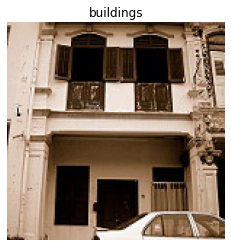

In [8]:
img = view_random_image(target_dir='/content/seg_train/seg_train/',
                  target_class='buildings')

## Print bunch of random images

In [9]:
# Get the class name programmatically
import pathlib
data_dir = pathlib.Path("/content/seg_train/seg_train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [10]:
random.choice(class_names)

'forest'

Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)


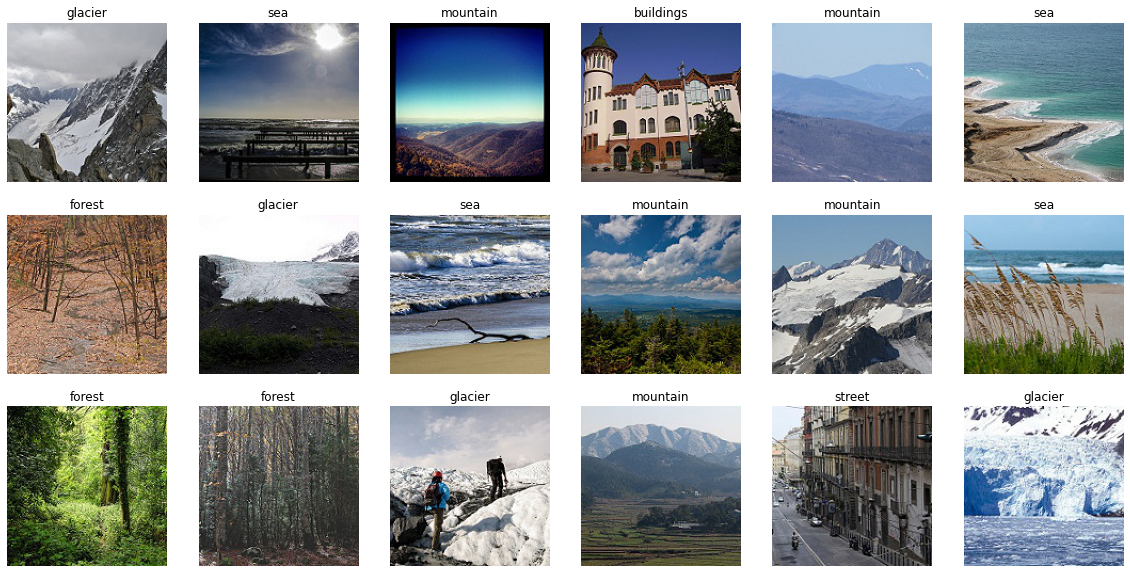

In [11]:
plt.figure(figsize=(20, 10))
for i in range(18):
  plt.subplot(3, 6, i+1)
  class_name = random.choice(class_names)
  img = view_random_image(target_dir='/content/seg_train/seg_train/',
                  target_class=class_name)

# Prepare data for model

In [12]:
train_dir = "/content/seg_train/seg_train"
test_dir = "/content/seg_test/seg_test"

In [13]:
# Create augmented data generator instance
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255.)

# Load data(data, label) from directory and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(150,150),
                                               batch_size=32,
                                               class_mode='categorical')
test_data = val_datagen.flow_from_directory(test_dir,
                                           target_size=(150,150),
                                           batch_size=32,
                                           class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Basic model Buildinig a CNN Classifier

In [14]:
len(class_names)

6

In [15]:
model_1 = Sequential([
  Conv2D(16, 3, padding='same', activation='relu', input_shape=(150,150,3)),
  MaxPool2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(class_names), activation='softmax')
])

model_1.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [17]:
history_1 = model_1.fit(train_data,
                    epochs=20,
                    batch_size=32,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/16
439/439 [==============================] - 75s 172ms/step - loss: 0.5843 - accuracy: 0.7876 - val_loss: 0.4825 - val_accuracy: 0.8297
Epoch 2/16
439/439 [==============================] - 75s 171ms/step - loss: 0.5418 - accuracy: 0.8063 - val_loss: 0.5156 - val_accuracy: 0.8177
Epoch 3/16
439/439 [==============================] - 74s 167ms/step - loss: 0.5213 - accuracy: 0.8117 - val_loss: 0.4858 - val_accuracy: 0.8213
Epoch 4/16
439/439 [==============================] - 73s 167ms/step - loss: 0.4900 - accuracy: 0.8190 - val_loss: 0.4499 - val_accuracy: 0.8370
Epoch 5/16
439/439 [==============================] - 73s 167ms/step - loss: 0.4718 - accuracy: 0.8286 - val_loss: 0.4609 - val_accuracy: 0.8397
Epoch 6/16
439/439 [==============================] - 73s 167ms/step - loss: 0.4495 - accuracy: 0.8362 - val_loss: 0.4429 - val_accuracy: 0.8470
Epoch 7/16
439/439 [==============================] - 73s 166ms/step - loss: 0.4438 - accuracy: 0.8375 - val_loss: 0.4393 - val_ac

In [18]:
model_1.evaluate(test_data)

94/94 [==============================] - 3s 34ms/step - loss: 0.3998 - accuracy: 0.8560


[0.3998130261898041, 0.8560000061988831]

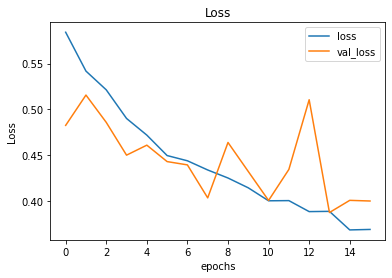

In [30]:
pd.DataFrame(history_1.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss');

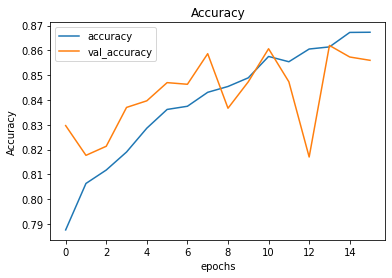

In [28]:
pd.DataFrame(history_1.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy');

# Transfer learning model

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

## Get ready data

In [11]:
# Get helper functions file
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [12]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [2]:
# upload kaggle API file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saimislam","key":"a3e06183b8072352e5ef8e53240d343a"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
#!kaggle datasets download -p destination -d download-link
!kaggle datasets download -d puneet6060/intel-image-classification

 94% 326M/346M [00:01<00:00, 237MB/s]
100% 346M/346M [00:01<00:00, 230MB/s]


In [5]:
import zipfile
zip_file_path = '/content/intel-image-classification.zip'
zip_ref = zipfile.ZipFile(zip_file_path, "r")
zip_ref.extractall()
zip_ref.close()

In [6]:
# Get the class name programmatically
import pathlib
data_dir = pathlib.Path("/content/seg_train/seg_train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [7]:
train_dir = "/content/seg_train/seg_train"
test_dir = "/content/seg_test/seg_test"

In [9]:
# Create augmented data generator instance
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255.)

# Load data(data, label) from directory and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(150,150),
                                               batch_size=32,
                                               class_mode='categorical')
test_data = val_datagen.flow_from_directory(test_dir,
                                           target_size=(150,150),
                                           batch_size=32,
                                           class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Creating feature extractor model callbacks

In [49]:
from helper_functions import create_tensorboard_callback


# Create ModelCheckpoint callback to save best model 
checkpoint_path = "feature_extraction_model_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

## Setting up mixed precision training

In [50]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")
mixed_precision.global_policy()

<Policy "mixed_float16">

## Feature extraction model

In [21]:
len(class_names)

6

In [51]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
# Create base model
input_shape = (150,150,3)
base_model = VGG16(include_top=False, weights = 'imagenet')
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
x = layers.Dense(len(class_names))(x)

# Create output layer and combine them
outputs = layers.Activation("softmax", dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 3078      
_________________________________________________________________
softmax_float32 (Activation) (None, 6)                 0         
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [52]:
# Checking layer dtype policy
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
vgg16 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_3 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [53]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_5 False float32 <Policy "float32">
block1_conv1 False float32 <Policy "mixed_float16">
block1_conv2 False float32 <Policy "mixed_float16">
block1_pool False float32 <Policy "mixed_float16">
block2_conv1 False float32 <Policy "mixed_float16">
block2_conv2 False float32 <Policy "mixed_float16">
block2_pool False float32 <Policy "mixed_float16">
block3_conv1 False float32 <Policy "mixed_float16">
block3_conv2 False float32 <Policy "mixed_float16">
block3_conv3 False float32 <Policy "mixed_float16">
block3_pool False float32 <Policy "mixed_float16">
block4_conv1 False float32 <Policy "mixed_float16">
block4_conv2 False float32 <Policy "mixed_float16">
block4_conv3 False float32 <Policy "mixed_float16">
block4_pool False float32 <Policy "mixed_float16">
block5_conv1 False float32 <Policy "mixed_float16">
block5_conv2 False float32 <Policy "mixed_float16">
block5_conv3 False float32 <Policy "mixed_float16">
block5_pool False float32 <Policy "mixed_float16">


In [54]:
history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[create_tensorboard_callback("training_logs",
                                                          "vgg16_mobile_feature_extract"),
                              model_checkpoint])

Saving TensorBoard log files to: training_logs/vgg16_mobile_feature_extract/20210601-160116
Epoch 1/10
439/439 [==============================] - 80s 179ms/step - loss: 1.0478 - accuracy: 0.6659 - val_loss: 0.6552 - val_accuracy: 0.8037
INFO:tensorflow:Assets written to: feature_extraction_model_checkpoints/assets
Epoch 2/10
439/439 [==============================] - 77s 176ms/step - loss: 0.6639 - accuracy: 0.7806 - val_loss: 0.5298 - val_accuracy: 0.8237
INFO:tensorflow:Assets written to: feature_extraction_model_checkpoints/assets
Epoch 3/10
439/439 [==============================] - 78s 178ms/step - loss: 0.5834 - accuracy: 0.8003 - val_loss: 0.4789 - val_accuracy: 0.8327
INFO:tensorflow:Assets written to: feature_extraction_model_checkpoints/assets
Epoch 4/10
439/439 [==============================] - 79s 180ms/step - loss: 0.5368 - accuracy: 0.8116 - val_loss: 0.4480 - val_accuracy: 0.8387
INFO:tensorflow:Assets written to: feature_extraction_model_checkpoints/assets
Epoch 5/10
4

In [55]:
result_feature_extract_model = model.evaluate(test_data)
result_feature_extract_model

94/94 [==============================] - 4s 43ms/step - loss: 0.4106 - accuracy: 0.8477


[0.41062092781066895, 0.8476666808128357]

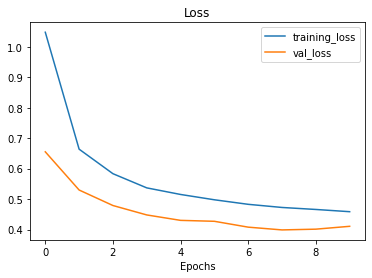

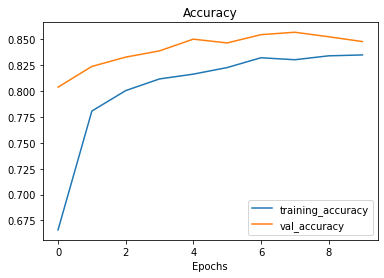

In [56]:
plot_loss_curves(history)

## Load and evaluate checkpoint weights

In [57]:
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 3078      
_________________________________________________________________
softmax_float32 (Activation) (None, 6)                 0         
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [58]:
cloned_model.load_weights(checkpoint_path)

In [59]:
cloned_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [60]:
cloned_model.evaluate(test_data)

94/94 [==============================] - 4s 42ms/step - loss: 0.3988 - accuracy: 0.8567


[0.39878663420677185, 0.8566666841506958]

## Setup all callbacks before final model

In [34]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [35]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

## Fine tune feature extraction model

In [36]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
# Create base model
input_shape = (150,150,3)
base_model = VGG16(include_top=False, weights = 'imagenet')
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# x = preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
x = layers.Dense(len(class_names))(x)

# Create output layer and combine them
outputs = layers.Activation("softmax", dtype=tf.float32, name='softmax_float32')(x)
model_fine_tune = tf.keras.Model(inputs, outputs)
model_fine_tune.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3078      
_________________________________________________________________
softmax_float32 (Activation) (None, 6)                 0         
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


In [37]:
# Set entire model trainable (no frozeen layer)
for layer in model_fine_tune.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) 
  # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
vgg16 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [39]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model_fine_tune.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_4 True float32 <Policy "float32">
block1_conv1 True float32 <Policy "mixed_float16">
block1_conv2 True float32 <Policy "mixed_float16">
block1_pool True float32 <Policy "mixed_float16">
block2_conv1 True float32 <Policy "mixed_float16">
block2_conv2 True float32 <Policy "mixed_float16">
block2_pool True float32 <Policy "mixed_float16">
block3_conv1 True float32 <Policy "mixed_float16">
block3_conv2 True float32 <Policy "mixed_float16">
block3_conv3 True float32 <Policy "mixed_float16">
block3_pool True float32 <Policy "mixed_float16">
block4_conv1 True float32 <Policy "mixed_float16">
block4_conv2 True float32 <Policy "mixed_float16">
block4_conv3 True float32 <Policy "mixed_float16">
block4_pool True float32 <Policy "mixed_float16">
block5_conv1 True float32 <Policy "mixed_float16">
block5_conv2 True float32 <Policy "mixed_float16">
block5_conv3 True float32 <Policy "mixed_float16">
block5_pool True float32 <Policy "mixed_float16">


In [40]:
# Compile the model
model_fine_tune.compile(loss="categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [41]:
# Start to fine-tune (all layers)
history_fine_tune = model_fine_tune.fit(train_data,
                                        epochs=20, # fine-tune for a maximum of 100 epochs
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                        callbacks=[create_tensorboard_callback("training_logs", "model_vgg_mobile_image_fine_tuning"), # track the model training logs
                                                    model_checkpoint, # save only the best model during training
                                                    early_stopping, # stop model after X epochs of no improvements
                                                    reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/model_vgg_mobile_image_fine_tuning/20210601-153352
Epoch 1/20
  1/439 [..............................] - ETA: 1:42:47 - loss: 2.0769 - accuracy: 0.1562

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f43e0fde8c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


439/439 [==============================] - 161s 336ms/step - loss: 0.5539 - accuracy: 0.8041 - val_loss: 0.3189 - val_accuracy: 0.8906
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
Epoch 2/20
439/439 [==============================] - 82s 187ms/step - loss: 0.3294 - accuracy: 0.8838 - val_loss: 0.3209 - val_accuracy: 0.8951
Epoch 3/20
439/439 [==============================] - 82s 187ms/step - loss: 0.2895 - accuracy: 0.8987 - val_loss: 0.2991 - val_accuracy: 0.9062
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
Epoch 4/20
439/439 [==============================] - 82s 186ms/step - loss: 0.2688 - accuracy: 0.9071 - val_loss: 0.2913 - val_accuracy: 0.8951
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
Epoch 5/20
439/439 [==============================] - 81s 184ms/step - loss: 0.2351 - accuracy: 0.9195 - val_loss: 0.2753 - val_accuracy: 0.9040
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
Epoch 6/20
439/439 [=========

In [61]:
model_fine_tune.evaluate(test_data)

94/94 [==============================] - 4s 42ms/step - loss: 0.2445 - accuracy: 0.9307


[0.24454675614833832, 0.9306666851043701]

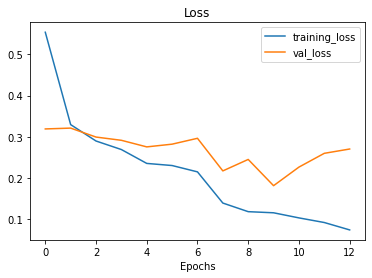

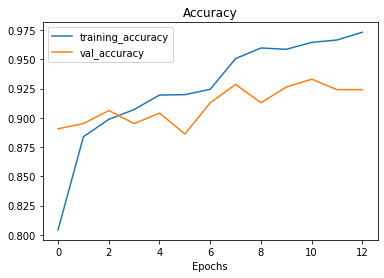

In [62]:
plot_loss_curves(history_fine_tune)

In [43]:
cloned_model_fine_tune = tf.keras.models.clone_model(model_fine_tune)
cloned_model_fine_tune.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3078      
_________________________________________________________________
softmax_float32 (Activation) (None, 6)                 0         
Total params: 14,717,766
Trainable params: 14,717,766
Non-trainable params: 0
_________________________________________________________________


In [44]:
cloned_model_fine_tune.load_weights(checkpoint_path)

In [46]:
cloned_model_fine_tune.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [47]:
cloned_model_fine_tune.evaluate(test_data)

94/94 [==============================] - 4s 43ms/step - loss: 0.2168 - accuracy: 0.9300


[0.2167755365371704, 0.9300000071525574]

## Make prediction using our final trained model

In [63]:
def load_and_prep_image(filename, img_shape=150, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [65]:
import os
pred_img = os.listdir("/content/seg_pred/seg_pred/")
import random
custom_images = []
for i in range(10):
  custom_images.append("/content/seg_pred/seg_pred/"+random.choice(pred_img))

custom_images

['/content/seg_pred/seg_pred/12914.jpg',
 '/content/seg_pred/seg_pred/15866.jpg',
 '/content/seg_pred/seg_pred/22324.jpg',
 '/content/seg_pred/seg_pred/16305.jpg',
 '/content/seg_pred/seg_pred/12812.jpg',
 '/content/seg_pred/seg_pred/1239.jpg',
 '/content/seg_pred/seg_pred/2585.jpg',
 '/content/seg_pred/seg_pred/17294.jpg',
 '/content/seg_pred/seg_pred/20823.jpg',
 '/content/seg_pred/seg_pred/15452.jpg']

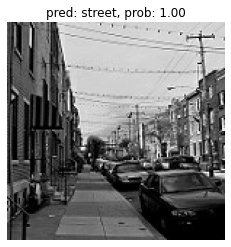

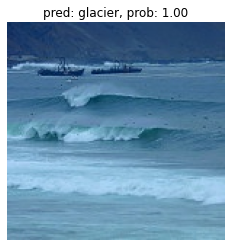

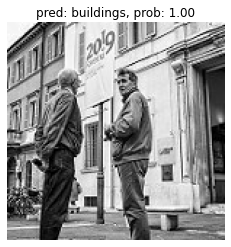

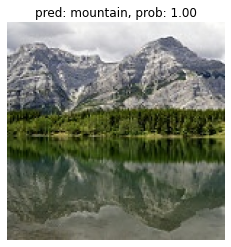

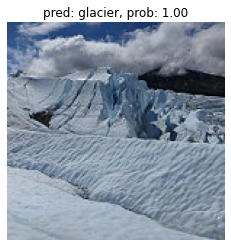

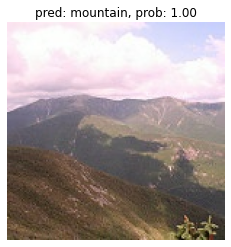

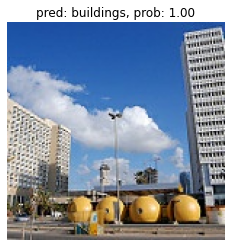

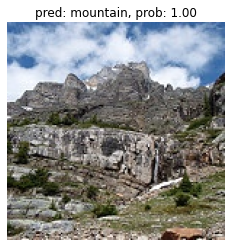

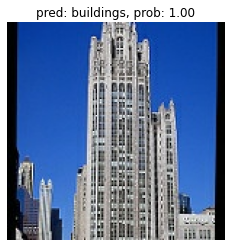

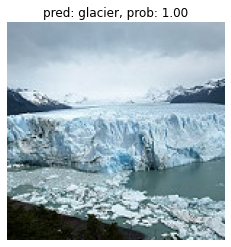

In [66]:
# Make predictions on custom images
for img in custom_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = cloned_model_fine_tune.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 150, 150, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

It is predicting correctly almost every images